<a href="https://colab.research.google.com/github/anwesha999/AssignmentTillDate/blob/master/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip

--2019-09-13 16:39:09--  https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 180902609 (173M) [application/zip]
Saving to: ‘warwick_qu_dataset_released_2016_07_08.zip’

warwick_qu_dataset_ 100%[===================>] 172.52M  19.6MB/s    in 14s     

2019-09-13 16:39:24 (12.3 MB/s) - ‘warwick_qu_dataset_released_2016_07_08.zip’ saved [180902609/180902609]



In [0]:
!unzip warwick_qu_dataset_released_2016_07_08.zip

Archive:  warwick_qu_dataset_released_2016_07_08.zip
   creating: Warwick QU Dataset (Released 2016_07_08)/
  inflating: Warwick QU Dataset (Released 2016_07_08)/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._.DS_Store  
  inflating: Warwick QU Dataset (Released 2016_07_08)/Grade.csv  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._Grade.csv  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_1.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_1.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_10.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_10.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_10_anno.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_10_anno.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_11.b

In [0]:
data_folder = "Warwick QU Dataset (Released 2016_07_08)/"

In [0]:
import pandas as pd
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from shutil import copyfile

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from tqdm import tqdm

In [0]:
df = pd.read_csv(data_folder + "Grade.csv")
df[["type","number"]] = df.name.str.split("_",expand=True)
display(df.groupby("type").agg("count"))

,name,patient ID,grade (GlaS),grade (Sirinukunwattana et al. 2015),number
type,,,,,
testA,60,60,60,60,60
testB,20,20,20,20,20
train,85,85,85,85,85


In [0]:
train_df = df[df["type"]=="train"]

In [0]:
# Image Augmentation: It is done to expand the training dataset in order to improve the performance and ability of the model to generalize
# Here, shift, flip, brightness, and zoom image data augmentation is done after resizing them 300*200 pixels 
# Here while augmenting the hyperparameter of gradient descent is taken to be 1 to control the number of training samples to work through before the model’s internal parameters are updated
aug = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

X = []
y = []
for i,r in tqdm(train_df[["name"," grade (GlaS)"]].iterrows()):
  label = r[" grade (GlaS)"]

  img = load_img(data_folder+r["name"]+".bmp").resize((300,200))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = aug.flow(img,batch_size=1)
  total=0
  for image in img:
    X.append(image[0].astype(int))
    y.append(label)
    total += 1
    if total == 20:
      break

In [0]:
len(X),len(y)

(1700, 1700)

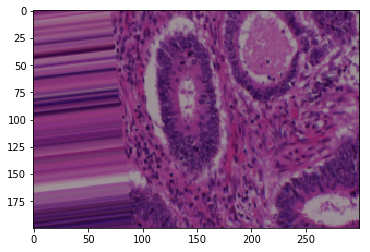

In [0]:
plt.imshow(X[4])

In [0]:
# Since its a binary classification model target is taken to be 0 or 1
img_map = {
    "malignant":0,
    "benign":1
          }

In [0]:
y = pd.Series(y).apply(lambda x: img_map[x.strip()])

In [0]:
#Model is trained via Alexnet Architecure & to avoid overfitting dropout is also used. The activation is done via relu and softmax
def alexnet(in_shape=(200,300,3), n_classes=1, opt='sgd'):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(96, 11, strides=4, activation='relu')(in_layer)
    pool1 = layers.MaxPool2D(3, 2)(conv1)
    conv2 = layers.Conv2D(256, 5, strides=1, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPool2D(3, 2)(conv2)
    conv3 = layers.Conv2D(384, 3, strides=1, padding='same', activation='relu')(pool2)
    conv4 = layers.Conv2D(256, 3, strides=1, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPool2D(3, 2)(conv4)
    flattened = layers.Flatten()(pool3)
    dense1 = layers.Dense(4096, activation='relu')(flattened)
    drop1 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(4096, activation='relu')(drop1)
    drop2 = layers.Dropout(0.5)(dense2)
    preds = layers.Dense(n_classes, activation='softmax')(drop2)

    model = Model(in_layer, preds)
    model.compile(loss="binary_crossentropy", optimizer=opt,
	              metrics=["accuracy"])
    return model

model = alexnet()
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 300, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 73, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 36, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 36, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 17, 256)       0         
_________________________________________

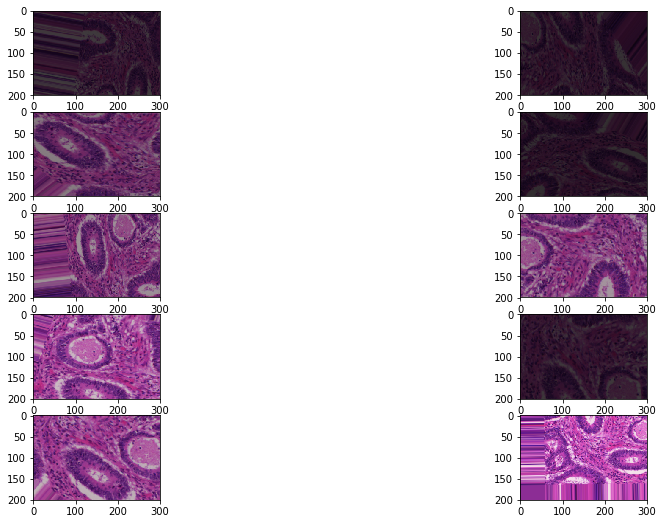

In [0]:
fig = plt.figure(figsize=(16,9)) 
ax = fig.subplots(5,2)
idx=0
for row in ax:
    for col in row:
        col.imshow(X[idx])
        idx+=1

plt.show()

In [29]:
model.fit(np.array(X), y, batch_size=8,epochs=100)

Epoch 1/100
1700/1700 [==============================] - 379s 223ms/step - loss: 9.0028 - acc: 0.4353
Epoch 2/100
1700/1700 [==============================] - 372s 219ms/step - loss: 9.0028 - acc: 0.4353
Epoch 3/100
1700/1700 [==============================] - 371s 218ms/step - loss: 9.0028 - acc: 0.4353
Epoch 4/100
1700/1700 [==============================] - 372s 219ms/step - loss: 9.0028 - acc: 0.4353
Epoch 5/100
1700/1700 [==============================] - 364s 214ms/step - loss: 9.0028 - acc: 0.4353
Epoch 6/100
1700/1700 [==============================] - 373s 219ms/step - loss: 9.0028 - acc: 0.4353
Epoch 7/100
1700/1700 [==============================] - 383s 225ms/step - loss: 9.0028 - acc: 0.4353
Epoch 8/100
1700/1700 [==============================] - 392s 231ms/step - loss: 9.0028 - acc: 0.4353
Epoch 9/100
1700/1700 [==============================] - 422s 248ms/step - loss: 9.0028 - acc: 0.4353
Epoch 10/100
1700/1700 [==============================] - 393s 231ms/step - loss: 

KeyboardInterrupt: ignored

In [0]:
## Preparing the test data-set

In [0]:
testA = df[df["type"]=="testA"]

In [32]:
X_testA = []
y_testA = []
for i,r in tqdm(testA[["name"," grade (GlaS)"]].iterrows()):
  label = r[" grade (GlaS)"]

  img = load_img(data_folder+r["name"]+".bmp").resize((300,200))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  X_testA.append(image[0].astype(int))
  y_testA.append(label)

60it [00:00, 213.53it/s]


In [0]:
pred = model.predict(np.array(X_testA))

In [0]:
pred = model.predict(np.array(X_testA))

In [36]:
#Output or Image Prediction is done here
pred[:5],y_testA[:5]

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32),
 [' benign', ' benign', ' benign', ' malignant', ' malignant'])